## やりたいこと
- [いままでやったこと](url:http://localhost:8889/notebooks/AEscript.py‗20200427.ipynb)の反映…モデルチューニングパラメータ
- kerasからtf.kerasへの完全移行
- 転移学習の準備 …モデルの保存とロード、ロードモデルによる推論処理
- その他細かなリファクタリング

In [1]:
"""
# プロトタイプ2020コアエンジン
## <機能>
- 保存されたWavファイルからデータセットを生成
    - Enviromentに保存された環境音データを使ってAugmentation
    - データセットの保存と読み込み
- オートエンコーダによる異常検知
    - 純オートエンコーダ及び、PCAによる疑似オートエンコーダを実装
    - オートエンコーダチューニングの為のグリッドサーチ
    - 異常度の定義 行列総和/MSE
- 学習済モデルの保存と呼び出し →転移学習への対応
"""

#%%
# cording = UTF-8
import os,re,random,copy
import scipy,librosa
import numpy as np
import pandas as pd             #ほとんど使わんけど
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import sklearn
import h5py

print ("Scipy version:{0}".format(scipy.__version__))
print ("Numpy version:{0}".format(np.__version__))
print ("Pandas version:{0}".format(pd.__version__))
print ("Tensorflow version:{0}".format(tf.__version__)) #赤線は無視
print ("tf.keras version:{0}".format(tf.keras.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))
print ("h5py version:{0}".format(h5py.__version__))

####################################初期化####################################
aug_amount = 100        #ファイルごとのAugmentationの回数
lr = 1e-01               #初期学習率
alpha = 0           #L2正則化の係数
dr_rate = 0.2           #ドロップアウト率
batch_size = 256         #オフライン学習時のバッチサイズ
epochs = 100            #学習時のエポック数(グリッドサーチ時は無効)
monitor = "val_loss"    #学習率減衰/早期打ち切りの指標
encode_dim = 1600        #オートエンコーダの圧縮次元
n_components = 0.999    #疑似AEの保持分散

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")
ok_dir = os.path.join(data_dir,"OK")
ng_dir = os.path.join(data_dir,"NG")
env_dir = os.path.join(data_dir,"environment")
log_dir = "./logs"       #Tensorboardログの保存パス
modeldir = "./models"   #学習済みモデルの保存パス

#学習用データファイル
datafile = "dataset2.npz"

##############################定義系オブジェクト##############################

#Augmentation関連関数のクラス
class Aug:
    def __init__(self,aug_amount,ok_dir,ng_dir,env_dir):
        self.aug_amount = aug_amount
        self.ok_dir = ok_dir
        self.ng_dir = ng_dir
        self.env_dir = env_dir

    #対象ディレクトリのファイル一覧を取得
    def get_file_list(self,dir):
        file_list = os.listdir(dir)
        print("get file_list :{}".format(file_list))
        return file_list
    
    #対象ディレクトリの最大ファイルをサーチ
    def wav_search(self,dir,f_list):
        #呼び出されるごとに初期化する
        wave_list = []
        file_size = 0
    
        return_path = os.path.abspath('./')
    
        os.chdir(dir)
        for i in f_list:
            search_index = re.search('.wav',i)
            if search_index:
                wave_list .append(i)
                if os.path.getsize(i) > file_size:
                    file_size = os.path.getsize(i)
                    largest_file = i
        
        os.chdir(return_path)   #カレントディレクトリを戻す
        print("get file :{0} ,file size:{1}"\
            .format(largest_file,file_size))
        return wave_list,largest_file,file_size
    
    #オーディオファイルの読み込み サンプルレート22.05kHz、モノラルで固定
    def load_wav(self,dir,file):
        #呼び出されるごとに初期化する
        wf = np.arange(0)

        f_path = os.path.join(dir,file)
        wf,sp_rate = librosa.load(f_path,sr=22050,mono = True)
        del sp_rate
        return wf
    
    #スペクトログラムの取得 パワースペクトラムのまま処理するならlibrosa不要
    def get_spg(self,wf):
        spg = np.arange(0)
        sp_f,sp_t,spg = scipy.signal.spectrogram(wf,fs=22050,
            window = np.hamming(1024),nfft =1024)
        #spg = librosa.power_to_db(spg)
        spg =spg.astype('float16')
        return sp_f,sp_t,spg

    #Augmentationの処理
    def aug_process(self,frame,dir,wave_list,env_file):
        #呼び出されるごとに初期化する
        length = 0
        count = 0
        wf = np.arange(0)

        length = int(frame * 1.2)
        for i in wave_list:
            wf = self.load_wav(dir,i)
            for j in range(self.aug_amount):
                start = random.randint(0,len(env_file)-length)
                aug_wav = copy.deepcopy(env_file[start : start + length])
                del start
                start = random.randint(0,len(aug_wav) - len(wf))
                aug_wav = aug_wav + random.gauss(1,0.05)
                aug_wav[ start:start + len(wf) ] = \
                    aug_wav[ start : start + len(wf) ] + wf
                sp_f,sp_t,spg = self.get_spg(aug_wav)
                spg = spg.reshape(1,len(sp_f),len(sp_t))
                try:
                    X_data
                except:
                    X_data = copy.deepcopy(spg)
                else:
                    X_data = np.vstack((X_data,spg))
                del start,aug_wav,sp_f,sp_t,spg
                count = count + 1
            del wf
            print("Augmentation done! total count = {}".format(count))

        return X_data    

    #データセットの作成 ここまでの関数は全部ここに集約される
    #最大ファイルサイズに合わせてフレームサイズを定義し
    #OK・NG各データセットを作成後、結合する

    def new_dataset(self):
        #OKNGそれぞれのファイルリストと最大ファイルを取得
        ok_filelist = self.get_file_list(self.ok_dir)
        ok_wave_list,ok_largeest_name,ok_largest_size = self.wav_search(self.ok_dir,ok_filelist)
        ng_filelist = self.get_file_list(self.ng_dir)
        ng_wave_list,ng_largeest_name,ng_largest_size = self.wav_search(self.ng_dir,ng_filelist)

        #OKNGの最大を比較
        if ok_largest_size>ng_largest_size:
            largest_dir = self.ok_dir
            lergest_name = ok_largeest_name
            print("largetst:OK")
        else:
            largest_dir = self.ng_dir
            lergest_name = ng_largeest_name
            print("largetst:NG")

        #最大フレームサイズを取得
        wf = self.load_wav(largest_dir,lergest_name)
        frame = int(len(wf))
        #wf = np.insert(wf,frame,np.empty(int(frame*0.2))) #1.2倍する
        #sp_f,sp_t,spg = get_spg(wf) 
        #X_initsize = (len(sp_f),len(sp_t))
        #del wf,sp_f,sp_t,spg
        del wf

        #環境音データをロード
        env_data = self.load_wav(self.env_dir,"env.wav")
    
        #OKデータセット作成
        X_ok = copy.deepcopy(
            self.aug_process(frame,self.ok_dir,ok_wave_list,env_data)
            )
        y_ok = np.zeros(len(X_ok),dtype = 'bool')   #OKデータをfalse(陰性)と定義

        #NGデータセット作成
        X_ng = copy.deepcopy(
            self.aug_process(frame,self.ng_dir,ng_wave_list,env_data)
            )
        y_ng = np.ones(len(X_ng),dtype = 'bool')    #NGデータをTrue(陽性)と定義

        #データセットの結合
        X_data = np.vstack((X_ok,X_ng))
        y_data = np.append(y_ok,y_ng)
        del X_ok,y_ok,X_ng,y_ng

        return X_data,y_data

#データ前処理のクラス
class Pproc:
    def __init__(self):
        pass

    #TrainとTestを分離
    def t_t_sprit(self,X_data,y_data,test_size):
        from sklearn.model_selection import train_test_split
        X_train,X_test,y_train,y_test = \
        train_test_split(
            X_data.reshape(len(X_data),-1),
            y_data,
            test_size = test_size)
        return X_train,X_test,y_train,y_test

    #スケーラー
    #def scaler(self):
    #    x = sklearn.preprocessing.MinMaxScaler()
    #    return x

    #AE学習用 Falseデータだけ抽出
    def m_sprit(self,X_mixed,y_mixed):
       #呼び出されるごとに初期化する
        try:
            X_sprit
        except:
            pass    #X_spritが存在しなければ何もしない
        else:
            del X_sprit #前のデータを消去する

        #y_mixedをboolianindexと見なし、論理値を反転してX_mixedから抽出
        X_sprit = X_mixed[np.logical_not(y_mixed)]

        return X_sprit

#分類機の定義
class Estimator:
    def __init__(self):
        pass

    #オートエンコーダの定義
    def AE(self,input_dim,encode_dim,lr,alpha,dr_rate):
        input_data = tf.keras.layers.Input(shape = (input_dim,))

        #エンコーダを定義
        encoder = tf.keras.layers.Dense(
            encode_dim,
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(alpha),
            )(input_data)
        encoder = tf.keras.layers.BatchNormalization()(encoder)
        encoder = tf.keras.layers.Dropout(dr_rate)(encoder)
        encoder = tf.keras.layers.Activation("relu")(encoder)

        #デコーダを定義 こっちにはドロップアウトは定義しない
        decoder = tf.keras.layers.Dense(
            input_dim,kernel_initializer="he_normal")(encoder)
        decoder = tf.keras.layers.BatchNormalization()(decoder)
        decoder = tf.keras.layers.Activation("sigmoid")(decoder)

        #モデルを定義
        x = tf.keras.Model(
            inputs = input_data,
            outputs = decoder
        )

        #最適化関数
        opt = tf.keras.optimizers.Nadam(lr = lr)

        x.compile(
            optimizer = opt,loss='binary_crossentropy',metrics=['accuracy']
            )

        return x

    #コールバック定義 早期打ち切り
    def cb_es(self,monitor):
        x = tf.keras.callbacks.EarlyStopping(
            monitor = monitor,
            patience= 3,
            min_delta = 0.0001)
        return x

    #コールバック定義 TensorBordへの出力 バリデーションデータの指定が必須
    #Tensorflow2.1.0 / keras 2.2.4-tfでは不具合があるらしい
    def cb_tb(self,log_dir):
        x = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            )
        return x

    #コールバック定義 自動学習率減衰(もともとNadamは減衰する decay=0.004)
    #Tensorflow2.1.0 / keras 2.2.4-tfでは不具合があるらしい
    def cb_rd(self,monitor):
        x = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = monitor,
            factor = 0.1,
            patience = 2,
            verbose= 1,
            min_lr = 1e-08
            )
        return x

    #コールバック定義 モデル保存
    #Tensorflow2.1.0 / keras 2.2.4-tfでは不具合があるらしい
    def cb_cp(self,modeldir,monitor):
        x = tf.keras.callbacks.ModelCheckpoint(
            filepath = os.path.join(modeldir,"AEmodel.hdf5"),
            monitor = monitor,
            save_best_only=True
        )
        '''
        以下備忘
        https://qiita.com/yukiB/items/f45f0f71bc9739830002 より

        >modelの保存，読み込みはmodel.to_json()/model.to_yaml()，
        >model_from_json()/model_from_yaml()を使用します．

        '
        from keras.models import Sequential, model_from_json

        json_string = model.to_json()
        model = model_from_json(json_string)
        '

        >学習したParameterの保存＆読み込みは，
        >save_weights/load_weightsを使用します(h5pyが必要)．

        '
        model.save_weights('param.hdf5')
        model.load_weights('param.hdf5')
        '
        '''
        return x

    #PCAによる疑似エンコーダの定義 PCA_pyの取り込み       
    def Pseudo_AE(self,n_components):
        x = sklearn.decomposition.PCA(n_components=n_components)
        return x

#誤差計算
class cal_Err:
    def __init__(self):
        pass

    def calc_sum(self,X_test,X_pred,y_test):
        diff_score =np.zeros(y_test.shape)
        for i in range(X_test.shape[0]):
            diff_score[i] = np.sum(np.abs(X_test[i]-X_pred[i]))
        
        return diff_score

    def calc_MSE(self,X_test,X_pred,y_test):
        diff_mse = np.zeros(y_test.shape)
        from sklearn.metrics import mean_squared_error
        for i in range(X_test.shape[0]):
            diff_mse[i] = sklearn.metrics.mean_squared_error(
                X_test[i],X_pred[i]
            )
        
        return diff_mse

#可視化
class Vis_pred:
    pass

#############################処理系オブジェクト#############################
#オートエンコーダのための前処理
class offl_pproc(Pproc):
    
    #トレーニング/テストデータ分離、False分離、スケーリング
    def offl_pproc(self,X_data,y_data):
        X_train,X_test,y_train,y_test = super().t_t_sprit(
            X_data,y_data,
            test_size=0.05
            )
        print("train/test sprited!!")
        del X_data,y_data

        X_train_ae = super().m_sprit(X_train,y_train)
        print(
        "X_train for Autoencoder was splited!!\n\
        amount/shape:{0}"
        .format(X_train_ae.shape)
        )

        #後で使うためにスケーラーをインスタンス化しておく
        #scaler = super().scaler()
        #X_train_ae = scaler.fit_transform(X_train_ae)
        #print("Scaling process is over!!")

        return X_train,X_test,y_train,y_test,X_train_ae #,scaler

#初期オフライン学習
class offl_AE(Estimator):
    
    def offl_AE_train(
        self,X_train_ae,encode_dim,lr,alpha,dr_rate,
        epochs,batch_size,
        monitor
        ):  #,log_dir,modeldir
        #エンコーダのインスタンス化
        x = super().AE(
                input_dim = X_train_ae.shape[1],   #スケーリング済みであること
                encode_dim = encode_dim,
                lr = lr,
                alpha = alpha,
                dr_rate = dr_rate
            )
        #コールバックの定義 今は早期打ち切りしか使ってない
        cb_es = super().cb_es(monitor = monitor)

        hist = x.fit(
            X_train_ae,X_train_ae,
            epochs = epochs,
            batch_size = batch_size,
            callbacks = [cb_es], #,cb_rd,cb_tb うまく動かない
            validation_split = 0.05,
            shuffle = True,
            use_multiprocessing=True
            )

        print('Autoencoder learning is over!')
        x.summary()

        #学習曲線の表示
        plt.subplot(121)
        plt.plot(hist.history['accuracy'])
        plt.plot(hist.history['val_accuracy'])
        plt.ylabel("accuracy")
        plt.xlabel("epochs")
        plt.legend(["Train","test"])
        plt.title("Accuracy")

        plt.subplot(122)
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.legend(["Train","test"])
        plt.title("Loss")

        plt.show()

        return x,hist

    def offl_PsdAE_train(self,X_train_ae,n_components):
        #エンコーダのインスタンス化
        x = super().Pseudo_AE(
                n_components=n_components
                )
        #学習処理
        x.fit(X_train_ae)

        #学習後の次元数を表示
        print(
            "PusedoAE learning is over!\n\
        n_components = {0}"
        .format(x.n_components_)
        )

        return x

#オートエンコーダグリッドサーチの実行
class AE_GS(Estimator):
    def __init__(self):
        pass
    
    def GS_param(self):
        pm = {
            'alpha':[1,0.01,1e-04,1e-06,1e-08],
            'lr':[1,0.01,1e-04,1e-06,1e-08],
            'dr_rate':[0.2],
            'batch_size':[50],
            'epochs':[10]
        }
        return pm

    #グリッドサーチの定義から処理まで一気に行う
    def GS_fit(self,X_train_ae,encode_dim,lr,alpha,dr_rate,epochs,batch_size):
        
        #Sklearnでラップ
        x = keras.wrappers.scikit_learn.KerasClassifier(
            build_fn = super().AE(
                input_dim = X_train_ae.shape[1],
                encode_dim = encode_dim,
                lr = lr,
                alpha = alpha,
                dr_rate = dr_rate
            ),
            epochs = epochs,
            batch_size = batch_size
        )  

        #サーチの実行
        y = sklearn.model_selection.GridSearchCV(
            estimator = x,
            param_grid = self.GS_param(),
            return_train_score = True,
            cv = 3,
            verbose = 2
        )
        
        y.fit(X_train_ae,X_train_ae)

        #レポートの表示
        print('Gridsearch is over!')
        print("Best parameters :{}".format(y.best_params_))
        print("Best cross-validation score :{}".format(y.best_score_))

        #テスト結果の一覧表示(データフレーム使用)
        #results_df = pd.DataFrame(y.cv_results_)
        #display(results_df)

        #ヒートマップの描画
        pm = self.GS_param()
        plt.pcolormesh(
            np.array(y.cv_results_['mean_test_score']).reshape(
                len(pm['alpha']),len(pm['lr'])
                )
            )
        plt.title('Result')
        plt.ylabel("alpha")
        plt.yticks(np.arange(len(pm['alpha'])),pm['alpha'])
        plt.xlabel("Larning Rate")
        plt.xticks(np.arange(len(pm['lr'])),pm['lr'])
        plt.colorbar()
        plt.show()

        return y

#推論処理 モデルインスタンスを受け取るので子クラスである必要はない
class Predictor:
    def __init__(self):
        pass

    def AE_pred(self,X_test,model):     #,scaler
        x = model.predict(X_test)
        print ("Prediction is finished!!")

        return x

    def PsdAE_pred(self,X_test,model):      #,scaler
        x = model.transform(X_test)   #次元圧縮する
        y = model.inverse_transform(x)       #元に戻す
        print ("Prediction is finished!!")

        return y


Scipy version:1.4.1
Numpy version:1.18.2
Pandas version:1.0.3
Tensorflow version:2.1.0
tf.keras version:2.2.4-tf
Scikit-Learn version:0.22.2.post1
h5py version:2.10.0


モデル定義のimport文をすべて削除し、tf.kerasを明示的に呼ぶように変更  
  
使用しているライブラリのバージョン情報を起動時に表示するように

In [2]:
#################################メイン処理#################################

#Augmentationインスタンスを生成しデータセット読み込み なければ作る
aug = Aug(
    aug_amount = aug_amount,
    ok_dir = ok_dir,
    ng_dir = ng_dir,
    env_dir = env_dir
    )

if os.path.exists(os.path.join(data_dir,datafile)) == False:
    X_data,y_data = aug.new_dataset()
    np.savez_compressed(os.path.join(data_dir,datafile),
        X = X_data,y = y_data)
    print("Data set saved!") #ファイルネーム表示機能つけること
else:
    load_data = np.load(os.path.join(data_dir,datafile))
    X_data =load_data['X']
    y_data = load_data['y']
    del load_data
    print("Data loaded!!")

X_shape = X_data.shape[1:]  #データの形状を取得


Data loaded!!


In [3]:
#前処理 トレーニングデータとテストデータを分離し、
#更にAE用のFalseデータのみに分離
pproc = offl_pproc()
X_train,X_test,y_train,y_test,X_train_ae = \
    pproc.offl_pproc(X_data,y_data)


train/test sprited!!
X_train for Autoencoder was splited!!
        amount/shape:(1901, 60021)


Train on 1805 samples, validate on 96 samples
Epoch 1/100
1805/1805 [==============================] - 51s 28ms/sample - loss: 0.5811 - accuracy: 0.3737 - val_loss: 0.4381 - val_accuracy: 0.4149
Epoch 2/100
1805/1805 [==============================] - 45s 25ms/sample - loss: 0.3688 - accuracy: 0.4019 - val_loss: 0.2723 - val_accuracy: 0.4149
Epoch 3/100
1805/1805 [==============================] - 45s 25ms/sample - loss: 0.2297 - accuracy: 0.4019 - val_loss: 0.1730 - val_accuracy: 0.4149
Epoch 4/100
1805/1805 [==============================] - 45s 25ms/sample - loss: 0.1490 - accuracy: 0.4019 - val_loss: 0.1172 - val_accuracy: 0.4149
Epoch 5/100
1805/1805 [==============================] - 45s 25ms/sample - loss: 0.1033 - accuracy: 0.4019 - val_loss: 0.0848 - val_accuracy: 0.4149
Epoch 6/100
1805/1805 [==============================] - 45s 25ms/sample - loss: 0.0763 - accuracy: 0.4019 - val_loss: 0.0649 - val_accuracy: 0.4149
Epoch 7/100
1805/1805 [==============================] - 46s

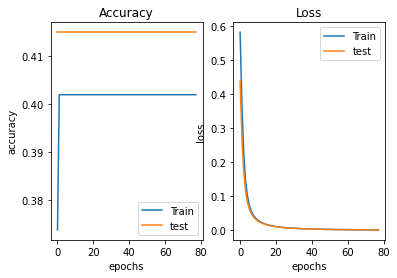

In [4]:
#AEによるオフライン学習 modelに学習済みモデル、histに学習記録が残る
AE = offl_AE()
model,hist = AE.offl_AE_train(X_train_ae,encode_dim,lr,alpha,dr_rate,epochs,batch_size,monitor)


いろいろやった結果lrは上限ギリギリの0.1に設定 それに伴いバッチサイズも256まで上げている  
早期打ち切りの閾値を0.001にしたので、78epochで学習が打ち切られている

In [5]:
#モデルを保存
model.save(
    filepath = os.path.join(modeldir,"AEmodel.hdf5"),
    )


この後誤って余計なセルを読ませてしまったので、期せずしてモデルロードの実験をすることに…

In [13]:
#途中で余計な構文を読ませてしまったのでデータをロードする
model = tf.keras.models.load_model(
    filepath = os.path.join(modeldir,"AEmodel.hdf5")
)


In [14]:
#推論を行う(AE)
pred = Predictor()
X_decode = pred.AE_pred(X_test,model)


Prediction is finished!!


ロードしたモデルで正常に推論処理ができている

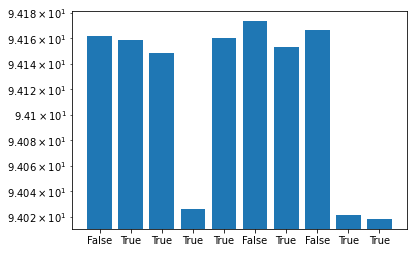

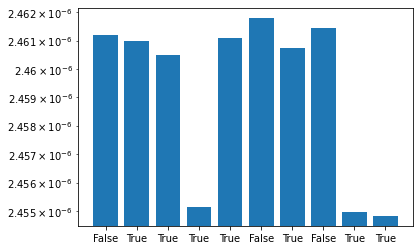

In [15]:
#誤差スコアの計算 どちらがいいのかわからないので総和とMSE双方を計算
#総和の差分を計算
diff_score =np.zeros(y_test.shape)
for i in range(X_test.shape[0]):
    diff_score[i] = np.sum(np.abs(X_test[i]-X_decode[i]))
plt.bar(range(10),diff_score[:10],tick_label = y_test[:10],log = True )
plt.show()

#MSEを計算
diff_mse = np.zeros(y_test.shape)
from sklearn.metrics import mean_squared_error
for i in range(X_test.shape[0]):
    diff_mse[i] = mean_squared_error(X_test[i],X_decode[i])
plt.bar(range(10),diff_mse[:10],tick_label = y_test[:10],log = True )
plt.show()


一応FalseとTrueの分離はできそうだ。  
一見気になるのが、Falseの誤差が大きく、Trueの誤差が小さいこと。逆じゃないのか…？

In [16]:
#疑似AE(PCA)によるオフライン学習 modelのみ残る
PsdAE = offl_AE()
model = PsdAE.offl_PsdAE_train(X_train_ae,n_components)


PusedoAE learning is over!
        n_components = 1595


In [17]:
#推論を行う(疑似AE)
pred = Predictor()
X_decode = pred.PsdAE_pred(X_test,model)


Prediction is finished!!


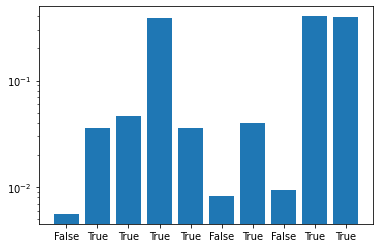

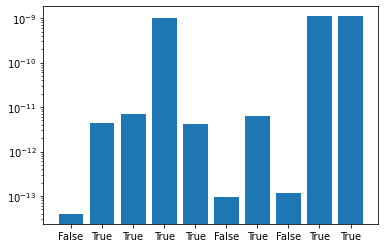

In [18]:
#誤差スコアの計算 どちらがいいのかわからないので総和とMSE双方を計算
#総和の差分を計算
diff_score =np.zeros(y_test.shape)
for i in range(X_test.shape[0]):
    diff_score[i] = np.sum(np.abs(X_test[i]-X_decode[i]))
plt.bar(range(10),diff_score[:10],tick_label = y_test[:10],log = True )
plt.show()

#MSEを計算
diff_mse = np.zeros(y_test.shape)
from sklearn.metrics import mean_squared_error
for i in range(X_test.shape[0]):
    diff_mse[i] = mean_squared_error(X_test[i],X_decode[i])
plt.bar(range(10),diff_mse[:10],tick_label = y_test[:10],log = True )
plt.show()


PCAだとちゃんと分離できており、かつFalseの誤差が小さい。 何かまだ間違っているらしい

## わかったこと
- kerasとtensorflowが混在した環境だと、tf.kerasを明示的に呼ばないと生keras側が呼ばれてしまう  
    両者は同じ機能を持つが微妙に構文等異なっており互換性がない  
- モデル作成上まだ何か間違っている部分があるらしく、FalseとTrueの誤差傾向が逆
- 誤差判定はMSEでも総和でもどちらでもいい
- モデルは圧縮をかけないととんでもないファイルサイズになる(約2G)

## 次にやること
- AEモデルのTrue/False誤差傾向が逆転している原因の解析
- 読み込んだモデルデータに新たなデータを学習させる処理の追加
- 初期データでの閾値決定  
    -線形分離が使えそうな気がするが…
- モデルデータの圧縮保存と展開 なんぼなんでもファイルサイズ大きすぎる
- コールバックの実装 tf.keras一本に絞ったのでまだできる気がするが…